In [2]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For permutation importance
from sklearn.inspection import permutation_importance

# For SHAP values
import shap

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

## Data preparation

In [3]:
df=pd.read_csv("../data/dairy_cows.csv")
df.head()

,ID,Species,Animal_Class,Welfare_Hazards_Animal,Welfare_Hazards_Consequences,Welfare_Hazards_Impact,Ease_of_Hazard_Mitigation,Welfare_Indicator,Indicator_Ease,Indicator_Resources
0,1,Dairy cows,Tie stalls,Pasture access,Gastro-enteric disorders,High,Moderate,Abdominal discomfort,Moderate,Low
1,1,Dairy cows,Cubicles,Pasture access,Gastro-enteric disorders,High,Moderate,Abdominal discomfort,Moderate,Low
2,2,Dairy cows,Tie stalls,Continuous housing for long periods,General disruption of behaviour,Low,Difficult,Agonistic behaviour,Moderate,Low
3,2,Dairy cows,Cubicles,Continuous housing for long periods,General disruption of behaviour,Low,Difficult,Agonistic behaviour,Moderate,Low
4,3,Dairy cows,Tie stalls,Insufficient space,Restriction of movement,High,Moderate,Agonistic interactions,Moderate,Medium


In [4]:
ease_mapping = {'Easy': 1, 'Moderate': 2, 'Difficult': 3}
resources_mapping = {'Low': 1, 'Medium': 2, 'High': 3}
impact_mapping = {'Low': 1, 'High': 2}

In [5]:
# Map 'Ease_of_Hazard_Mitigation'
df['Ease_of_Hazard_Mitigation_Encoded'] = df['Ease_of_Hazard_Mitigation'].map(ease_mapping)

# Map 'Indicator_Ease'
df['Indicator_Ease_Encoded'] = df['Indicator_Ease'].map(ease_mapping)

# Map 'Indicator_Resources'
df['Indicator_Resources_Encoded'] = df['Indicator_Resources'].map(resources_mapping)

# Map 'Welfare_Hazards_Impact' (Target Variable)
df['Welfare_Hazards_Impact_Encoded'] = df['Welfare_Hazards_Impact'].map(impact_mapping)
df.head()

,ID,Species,Animal_Class,Welfare_Hazards_Animal,Welfare_Hazards_Consequences,Welfare_Hazards_Impact,Ease_of_Hazard_Mitigation,Welfare_Indicator,Indicator_Ease,Indicator_Resources,Ease_of_Hazard_Mitigation_Encoded,Indicator_Ease_Encoded,Indicator_Resources_Encoded,Welfare_Hazards_Impact_Encoded
0,1,Dairy cows,Tie stalls,Pasture access,Gastro-enteric disorders,High,Moderate,Abdominal discomfort,Moderate,Low,2,2,1,2
1,1,Dairy cows,Cubicles,Pasture access,Gastro-enteric disorders,High,Moderate,Abdominal discomfort,Moderate,Low,2,2,1,2
2,2,Dairy cows,Tie stalls,Continuous housing for long periods,General disruption of behaviour,Low,Difficult,Agonistic behaviour,Moderate,Low,3,2,1,1
3,2,Dairy cows,Cubicles,Continuous housing for long periods,General disruption of behaviour,Low,Difficult,Agonistic behaviour,Moderate,Low,3,2,1,1
4,3,Dairy cows,Tie stalls,Insufficient space,Restriction of movement,High,Moderate,Agonistic interactions,Moderate,Medium,2,2,2,2


In [6]:
nominal_vars = [
    'Animal_Class',
    'Welfare_Hazards_Animal',
    'Welfare_Hazards_Consequences',
    'Welfare_Indicator'
]

df_encoded = pd.get_dummies(df, columns=nominal_vars)
df_encoded.drop([
    'ID',
    'Species',  # If only one unique value
    'Ease_of_Hazard_Mitigation',
    'Indicator_Ease',
    'Indicator_Resources',
    'Welfare_Hazards_Impact'  # Original target variable
], axis=1, inplace=True)
                            
df_encoded.head()

,Ease_of_Hazard_Mitigation_Encoded,Indicator_Ease_Encoded,Indicator_Resources_Encoded,Welfare_Hazards_Impact_Encoded,Animal_Class_Cubicles,Animal_Class_Tie stalls,Welfare_Hazards_Animal_Being tied up temporarily,Welfare_Hazards_Animal_Being tied without exercise for long periods,Welfare_Hazards_Animal_Continuous housing for long periods,Welfare_Hazards_Animal_Delayed calving intervention,...,Welfare_Indicator_Teat disorders,Welfare_Indicator_Time budgets (disruption of behaviour),"Welfare_Indicator_Time budgets (increased standing, decreased lying)",Welfare_Indicator_Time budgets (lack of rest),Welfare_Indicator_Time budgets (prevention of behaviour),Welfare_Indicator_Time budgets (reduced behavioural repertoire),Welfare_Indicator_Time spent looking out of pen,Welfare_Indicator_Vocalisations,Welfare_Indicator_Walking distance,Welfare_Indicator_Weight loss (adults) or restricted weight gain (calves)
0,2,2,1,2,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2,2,1,2,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,2,1,1,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,3,2,1,1,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,2,2,2,2,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Remove unnecessary columns

### Correlation Matrix

In [7]:
corr_matrix = df_encoded.corr()

### Identify Near-Zero Variance Variables

In [13]:

variance = df_encoded.var()
# Set variance threshold
variance_threshold = 0.006

# Identify variables with variance below the threshold
near_zero_variance_vars = variance[variance < variance_threshold].index.tolist()

print("Near-zero variance variables:", near_zero_variance_vars)

Near-zero variance variables: ['Welfare_Hazards_Animal_Delayed calving intervention', 'Welfare_Hazards_Animal_Difficulty calving because of the sire', 'Welfare_Hazards_Animal_Excessive noise (constant or sudden)', 'Welfare_Hazards_Animal_Inadequate housing design', 'Welfare_Hazards_Animal_Lack of environmental enrichment', 'Welfare_Hazards_Animal_Milking robot breakdown', 'Welfare_Hazards_Animal_Milking robot not used by cow', 'Welfare_Hazards_Animal_Mixing animals from different groups ', 'Welfare_Hazards_Animal_Poor calving conditions (calving management)', 'Welfare_Hazards_Animal_Poor pasture quality', 'Welfare_Hazards_Animal_Poor quality feed (low nutritive value)', 'Welfare_Hazards_Animal_Poor quality feed (pathogens/toxins)', 'Welfare_Hazards_Animal_Tie stall collar (injury)', 'Welfare_Hazards_Animal_Too few feeding places  ', 'Welfare_Hazards_Animal_Underfeeding', 'Welfare_Hazards_Consequences_Bone lesions (incl. fractures and dislocations)', 'Welfare_Hazards_Consequences_Inabil

### Remove near zero variance variables

In [14]:
df_encoded.drop(columns=near_zero_variance_vars, inplace=True)

### Highly Correlated Variables

In [15]:
corr_matrix = df_encoded.corr()

corr_threshold = 0.9

abs_corr_matrix = corr_matrix.abs()

upper_tri = abs_corr_matrix.where(np.triu(np.ones(abs_corr_matrix.shape), k=1).astype(bool))

high_corr_var_pairs = [(column, row) for column in upper_tri.columns for row in upper_tri.index if upper_tri.loc[row, column] > corr_threshold]

print("Highly correlated variable pairs:")
for var_pair in high_corr_var_pairs:
    print(var_pair[0], "<-->", var_pair[1], "with correlation:", abs_corr_matrix.loc[var_pair[1], var_pair[0]])


Highly correlated variable pairs:
Animal_Class_Tie stalls <--> Animal_Class_Cubicles with correlation: 0.9999999999999997
Welfare_Hazards_Consequences_Gastro-enteric disorders <--> Welfare_Hazards_Animal_Pasture access with correlation: 1.0
Welfare_Indicator_Body condition scoring <--> Welfare_Hazards_Consequences_Prolonged hunger with correlation: 1.0
Welfare_Indicator_Calving records (death of cow) <--> Welfare_Hazards_Consequences_Mortality with correlation: 1.0
Welfare_Indicator_Coat condiition / cleanliness <--> Welfare_Hazards_Consequences_Skin disorders (other than soft tissue lesions and integument damage) with correlation: 1.0
Welfare_Indicator_Metabolic disorders <--> Welfare_Hazards_Consequences_Metabolic disorders with correlation: 1.0


### Remove redudentent variables

In [16]:
variables_to_drop = set()

# For each pair, compare their correlation with the output variable
for col1, col2 in high_corr_var_pairs:
    # Compute correlation with the output variable
    corr_col1_output = abs(df_encoded[col1].corr(df_encoded['Welfare_Hazards_Impact_Encoded']))
    corr_col2_output = abs(df_encoded[col2].corr(df_encoded['Welfare_Hazards_Impact_Encoded']))
    
    # Decide which variable to drop
    if corr_col1_output >= corr_col2_output:
        variables_to_drop.add(col2)
    else:
        variables_to_drop.add(col1)

print("Variables to drop due to high correlation:")
print(variables_to_drop)

Variables to drop due to high correlation:
{'Welfare_Hazards_Consequences_Mortality', 'Welfare_Hazards_Animal_Pasture access', 'Welfare_Hazards_Consequences_Skin disorders (other than soft tissue lesions and integument damage)', 'Welfare_Hazards_Consequences_Prolonged hunger', 'Welfare_Hazards_Consequences_Metabolic disorders', 'Animal_Class_Cubicles'}


In [17]:
df_encoded.drop(columns=list(variables_to_drop), inplace=True)


# Modeling

In [12]:
import pandas as pd
import numpy as np

# Assuming df_encoded is your preprocessed DataFrame
# Separate features (X) and target variable (y)
X = df_encoded.drop('Welfare_Hazards_Impact_Encoded', axis=1)
y = df_encoded['Welfare_Hazards_Impact_Encoded']

In [13]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# For XGBoost (optional)
# !pip install xgboost
from xgboost import XGBClassifier


In [15]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
}

In [16]:
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} trained successfully.")

Logistic Regression trained successfully.
Decision Tree trained successfully.
Random Forest trained successfully.
Support Vector Machine trained successfully.
K-Nearest Neighbors trained successfully.
Gradient Boosting trained successfully.


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


In [18]:
# Initialize a DataFrame to store the results
evaluation_results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

for name, model in models.items():
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=2)
    recall = recall_score(y_test, y_pred, pos_label=2)
    f1 = f1_score(y_test, y_pred, pos_label=2)
    
    # Append the results
    evaluation_results.loc[len(evaluation_results)] = {
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

    
    # Print the classification report
    print(f"\nClassification Report for {name}:\n")
    print(classification_report(y_test, y_pred, target_names=['Low Impact', 'High Impact']))
    
    # Display the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix for {name}:\n{cm}\n")



Classification Report for Logistic Regression:

              precision    recall  f1-score   support

  Low Impact       1.00      1.00      1.00        39
 High Impact       1.00      1.00      1.00        39

    accuracy                           1.00        78
   macro avg       1.00      1.00      1.00        78
weighted avg       1.00      1.00      1.00        78

Confusion Matrix for Logistic Regression:
[[39  0]
 [ 0 39]]


Classification Report for Decision Tree:

              precision    recall  f1-score   support

  Low Impact       1.00      1.00      1.00        39
 High Impact       1.00      1.00      1.00        39

    accuracy                           1.00        78
   macro avg       1.00      1.00      1.00        78
weighted avg       1.00      1.00      1.00        78

Confusion Matrix for Decision Tree:
[[39  0]
 [ 0 39]]


Classification Report for Random Forest:

              precision    recall  f1-score   support

  Low Impact       1.00      1.00     

In [19]:
# Display the evaluation results
print("\nEvaluation Results:")
print(evaluation_results)


Evaluation Results:
                    Model  Accuracy  Precision    Recall  F1 Score
0     Logistic Regression  1.000000   1.000000  1.000000  1.000000
1           Decision Tree  1.000000   1.000000  1.000000  1.000000
2           Random Forest  1.000000   1.000000  1.000000  1.000000
3  Support Vector Machine  1.000000   1.000000  1.000000  1.000000
4     K-Nearest Neighbors  0.974359   0.974359  0.974359  0.974359
5       Gradient Boosting  1.000000   1.000000  1.000000  1.000000


In [20]:

def normalize_importances(importances):
    total = np.sum(importances)
    if total > 0:
        return importances / total
    else:
        return importances


In [21]:
feature_importances = {}
feature_names = X.columns

## Feature Importance

### Logistic Regression

In [22]:
# Logistic Regression coefficients
model = models['Logistic Regression']

# Ensure features are standardized for meaningful coefficients
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Retrain the model with scaled features
model.fit(X_train_scaled, y_train)

# Get absolute coefficients as importance
importances = np.abs(model.coef_[0])
importances = normalize_importances(importances)

feature_importances['Logistic Regression'] = importances


### Decision Tree

In [23]:
model = models['Decision Tree']
importances = model.feature_importances_
importances = normalize_importances(importances)
feature_importances['Decision Tree'] = importances


### Random Forest

In [24]:
model = models['Random Forest']
importances = model.feature_importances_
importances = normalize_importances(importances)
feature_importances['Random Forest'] = importances


### Gradient Boosting

In [25]:
model = models['Gradient Boosting']
importances = model.feature_importances_
importances = normalize_importances(importances)
feature_importances['Gradient Boosting'] = importances


### Support Vector Machine

In [26]:
model = models['Support Vector Machine']

# Use permutation importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
importances = perm_importance.importances_mean
importances = normalize_importances(importances)
feature_importances['Support Vector Machine'] = importances


### K-Nearest Neighbors

In [27]:
model = models['K-Nearest Neighbors']

# Use permutation importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
importances = perm_importance.importances_mean
importances = normalize_importances(importances)
feature_importances['K-Nearest Neighbors'] = importances


### FE analysis

In [29]:
importances_df = pd.DataFrame(index=feature_names)

# Add importances from each model
for model_name, importances in feature_importances.items():
    importances_df[model_name] = importances

# Display the DataFrame
importances_df.head()

,Logistic Regression,Decision Tree,Random Forest,Gradient Boosting,Support Vector Machine,K-Nearest Neighbors
Ease_of_Hazard_Mitigation_Encoded,0.004221,0.00000,0.008369,3.580113e-17,0.0,6.976744e-02
Indicator_Ease_Encoded,0.023238,0.00000,0.077347,1.803726e-02,0.0,-7.751938e-03
Indicator_Resources_Encoded,0.025649,0.22874,0.075662,9.521329e-02,0.0,3.953488e-01
Animal_Class_Tie stalls,0.000564,0.00000,0.003283,5.214730e-18,0.0,-3.875969e-02
Welfare_Hazards_Animal_Being tied up temporarily,0.002524,0.00000,0.002267,7.119276e-07,0.0,-6.712976e-17


In [31]:
# Function to rank features
def rank_features(importances):
    return importances.rank(ascending=False)

# Apply ranking
ranked_importances = importances_df.apply(rank_features, axis=0)
ranked_importances

,Logistic Regression,Decision Tree,Random Forest,Gradient Boosting,Support Vector Machine,K-Nearest Neighbors
Ease_of_Hazard_Mitigation_Encoded,60.0,45.0,25.0,26.0,44.0,7.0
Indicator_Ease_Encoded,13.0,45.0,3.0,11.0,44.0,70.0
Indicator_Resources_Encoded,11.0,1.0,4.0,5.0,44.0,1.0
Animal_Class_Tie stalls,76.0,45.0,47.0,29.0,44.0,76.0
Welfare_Hazards_Animal_Being tied up temporarily,69.0,45.0,50.0,24.0,44.0,66.0
...,...,...,...,...,...,...
Welfare_Indicator_Time budgets (disruption of behaviour),15.0,45.0,10.0,53.5,44.0,73.5
Welfare_Indicator_Time budgets (lack of rest),19.0,45.0,24.0,53.5,44.0,41.5
Welfare_Indicator_Time budgets (prevention of behaviour),36.0,45.0,27.0,53.5,44.0,11.0
Welfare_Indicator_Time spent looking out of pen,74.0,45.0,67.0,53.5,44.0,41.5


In [33]:
top_n = 15
top_features_per_model = {}

for model_name in importances_df.columns:
    # Get top N features for the model
    top_features = importances_df[model_name].sort_values(ascending=False).head(top_n).index.tolist()
    top_features_per_model[model_name] = top_features


In [34]:
common_features = set(feature_names)

for features in top_features_per_model.values():
    common_features = common_features.intersection(features)

print("Features important across all models:")
print(common_features)


Features important across all models:
{'Welfare_Hazards_Consequences_Locomotor disorders (including lameness)', 'Welfare_Hazards_Consequences_General disruption of behaviour', 'Welfare_Hazards_Consequences_Resting problems', 'Welfare_Hazards_Consequences_Environmental stress'}


In [35]:
from collections import Counter

# Flatten the list of top features from all models
all_top_features = [feature for features in top_features_per_model.values() for feature in features]

# Count occurrences
feature_counts = Counter(all_top_features)

# Features appearing in at least K models
k = len(models) - 1  # For example, features appearing in at least (total models - 1)
important_features = [feature for feature, count in feature_counts.items() if count >= k]

print(f"Features important in at least {k} models:")
print(important_features)


Features important in at least 5 models:
['Welfare_Hazards_Consequences_General disruption of behaviour', 'Welfare_Hazards_Consequences_Environmental stress', 'Welfare_Hazards_Consequences_Soft tissue lesions and integument damage', 'Welfare_Hazards_Consequences_Resting problems', 'Welfare_Hazards_Consequences_Locomotor disorders (including lameness)', 'Welfare_Hazards_Consequences_Inability to perform comfort behaviour', 'Welfare_Hazards_Consequences_Separation stress', 'Welfare_Hazards_Consequences_Restriction of movement', 'Indicator_Resources_Encoded', 'Welfare_Hazards_Consequences_Cold stress']


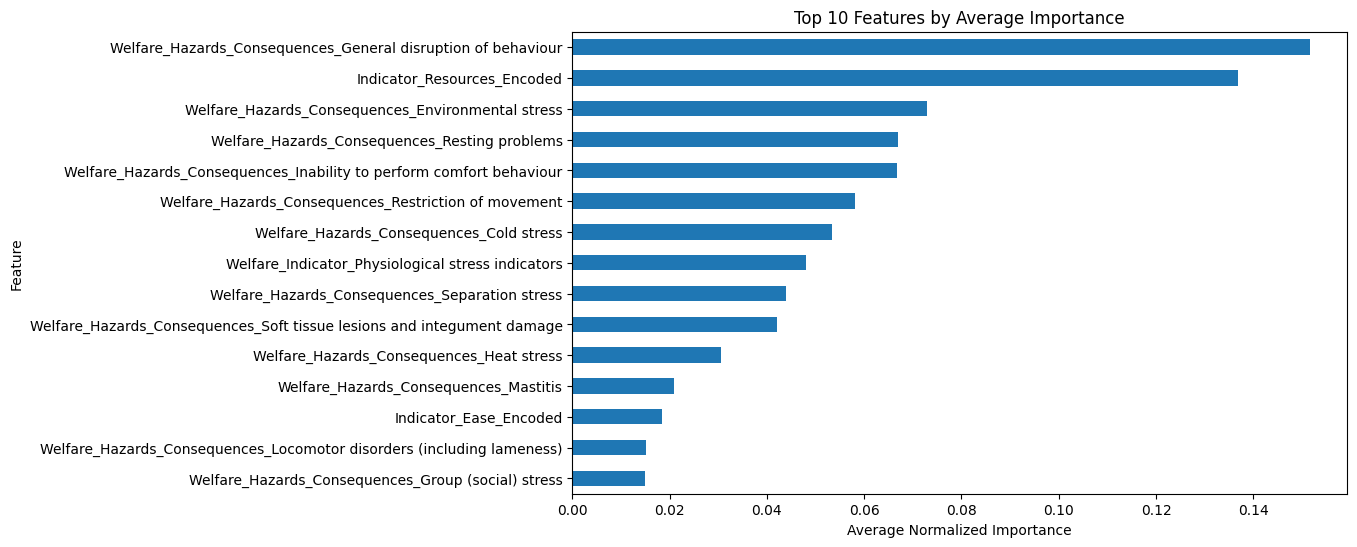

In [37]:
# Calculate average importance
importances_df['Average Importance'] = importances_df.mean(axis=1)

# Sort features by average importance
importances_df.sort_values(by='Average Importance', ascending=False, inplace=True)

# Plot the top 10 features
top_features = importances_df.head(15)

top_features['Average Importance'].plot(kind='barh', figsize=(10, 6), title='Top 10 Features by Average Importance', xlim=(0, None))
plt.xlabel('Average Normalized Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()
